In [1]:
import concurrent.futures as fs
import boto3
import io
import time
import numpy as np
import fcntl
from multiprocessing import Process
from multiprocessing import Process, Lock, Pipe

In [11]:
def do_gemm(A,B, tid):
    a = time.time()
    for i in range(3):
        C = A@B
        pass
    flops = 6*A.shape[0]*A.shape[1]*B.shape[1]
    b = time.time()
    flop_rate = flops/((b - a)*1e9)
    return A, flops,a,b
    
def do_io_write(A, tid, shard_idx=0):
    a = time.time()
    client = boto3.client('s3', use_ssl=False)
    size = A.nbytes
    b = time.time()
    #return size,a,b
    bio = io.BytesIO()
    np.save(bio,A)
    key = "iotest/read_{0}".format(shard_idx)
    z = client.put_object(Key=key, Bucket="numpywrennsdi", Body=bio.getvalue())
    b = time.time()
    write_rate = size/((b - a) * 1e6)
    return size,a,b

def do_io_read(tid, shard_idx=0):
    a = time.time()
    client = boto3.client('s3', use_ssl=False)
    key = "iotest/read_{0}".format(shard_idx)
    data = client.get_object(Key="iotest/read_{0}".format(shard_idx), Bucket="numpywrennsdi")["Body"].read()
    bio = io.BytesIO(data)
    A = np.load(bio)
    size = A.nbytes
    b = time.time()
    read_rate = size/((b - a) * 1e6)
    return A, size,a,b

    
    
    

In [20]:
A = np.random.randn(2048,2048)
B = np.random.randn(2048,2048)

In [21]:
[do_io_write(A, i) for i in range(10)]
[do_io_write(B, i) for i in range(10)]

[(33554432, 1536873708.764491, 1536873709.6523652),
 (33554432, 1536873709.6525085, 1536873710.4407222),
 (33554432, 1536873710.440885, 1536873711.2443762),
 (33554432, 1536873711.2445364, 1536873712.1376617),
 (33554432, 1536873712.1378279, 1536873713.6444783),
 (33554432, 1536873713.6446466, 1536873714.5469077),
 (33554432, 1536873714.5470636, 1536873715.4008756),
 (33554432, 1536873715.401035, 1536873716.1841311),
 (33554432, 1536873716.1842916, 1536873717.1785047),
 (33554432, 1536873717.17867, 1536873718.1683908)]

In [22]:
do_io_write(A, tid=0)

(33554432, 1536873718.1727538, 1536873719.0670383)

In [23]:
do_io_read(0)

(array([[ 0.54439819,  1.58146251,  0.14308054, ...,  0.93741531,
          1.77960052, -0.85412487],
        [ 0.47763034,  0.75308372,  0.58645173, ...,  0.13248176,
          0.2105735 , -0.58093845],
        [-0.63553792,  0.89116859, -2.56674101, ..., -0.60674104,
         -1.37955537, -0.44009287],
        ...,
        [-0.9220258 , -0.807776  , -1.09049624, ..., -0.11674078,
         -0.50827568,  0.50610303],
        [ 2.13321545,  0.45971677,  2.17183117, ...,  0.04117226,
          0.62752621,  1.31219763],
        [ 0.90021404,  1.07863819, -0.12881333, ...,  1.09205134,
         -1.32029589, -2.91073616]]),
 33554432,
 1536873719.070914,
 1536873719.4411883)

In [26]:
do_gemm(A,B,0)

(array([[ 0.54439819,  1.58146251,  0.14308054, ...,  0.93741531,
          1.77960052, -0.85412487],
        [ 0.47763034,  0.75308372,  0.58645173, ...,  0.13248176,
          0.2105735 , -0.58093845],
        [-0.63553792,  0.89116859, -2.56674101, ..., -0.60674104,
         -1.37955537, -0.44009287],
        ...,
        [-0.9220258 , -0.807776  , -1.09049624, ..., -0.11674078,
         -0.50827568,  0.50610303],
        [ 2.13321545,  0.45971677,  2.17183117, ...,  0.04117226,
          0.62752621,  1.31219763],
        [ 0.90021404,  1.07863819, -0.12881333, ...,  1.09205134,
         -1.32029589, -2.91073616]]),
 51539607552,
 1536877715.579315,
 1536877715.7405624)

In [25]:
def runner(A,B,j,read_lock, compute_lock, write_lock, pipe, iters=3):
    total_reads = 0
    total_writes = 0
    total_compute = 0
    read_times = []
    compute_times = []
    write_times = []
    for i in range(iters):
        t = time.time()
        read_lock.acquire()
        A, reads, r_start, r_end = do_io_read(shard_idx=j, tid=j)
        total_reads += reads
        read_times.append((r_start, r_end))
        A, reads, r_start, r_end = do_io_read(shard_idx=j, tid=j)
        total_reads += reads
        read_times.append((r_start, r_end))
        B, reads, r_start, r_end = do_io_read(shard_idx=j, tid=j)
        total_reads += reads
        read_times.append((r_start, r_end))
        start = time.time()
        e = time.time()
        t = time.time()
        total_reads += reads
        read_lock.release()
        e = time.time()
        t = time.time()
        compute_lock.acquire()
        e = time.time()
        C, flops, start, end = do_gemm(A, B, tid=i)
        compute_times.append((start, end))
        total_compute += flops
        compute_lock.release()
        write_lock.acquire()
        writes,start, end = do_io_write(C, shard_idx=j, tid=j)
        write_times.append((start, end))
        writes,start, end = do_io_write(C, shard_idx=j, tid=j)
        write_times.append((start, end))
        write_lock.release()
        total_writes += writes
    pipe.send([total_reads, total_writes, total_compute, read_times, write_times, compute_times])
        
    
    
    

In [18]:
def calculate_aggregate_throughput(n_procs=2, n_iters=1):
    t = time.time()
    futures = []
    read_lock = Lock() 
    write_lock = Lock() 
    compute_lock = Lock() 
    parent_conns = []
    read_intervals = []
    write_intervals = []
    compute_intervals = []
    for i in range(n_procs):
        parent_conn, child_conn = Pipe()
        p = Process(target=runner, args=(A,B,i,read_lock,compute_lock,write_lock,child_conn,n_iters))
        p.start()
        parent_conns.append(parent_conn)
    total_read = 0
    total_write = 0
    total_compute = 0
    read_times = []
    for p in parent_conns:
        #print("reading from parent")
        res = p.recv()
        print(res)
        total_read += res[0]
        total_compute += res[2]
        total_write += res[1]
        read_intervals.extend(res[3])
        write_intervals.extend(res[4])
        compute_intervals.extend(res[5])
    e = time.time()
    read_rate = total_read/((e - t)*1e6)
    write_rate = total_write/((e - t)*1e6)
    compute_rate = total_compute/((e - t)*1e9)
    print("aggregate compute rate ", compute_rate)
    print("aggregate read rate ", read_rate)
    print("aggregate write rate ", write_rate)
    return read_intervals, write_intervals, compute_intervals
        
    
    

In [19]:
read_intervals, write_intervals, computer_intervals = calculate_aggregate_throughput(n_procs=3, n_iters=5)

Process Process-2:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-17-23c25d89a975>", line 11, in runner
    A, reads, r_start, r_end = do_io_read(shard_idx=j, tid=j)
  File "<ipython-input-11-ff6ac829b0da>", line 29, in do_io_read
    data = client.get_object(Key="iotest/read_{0}".format(shard_idx), Bucket="numpywrennsdi")["Body"].read()
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/botocore/client.py", line 314, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/botocore/client.py", line 612, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.NoSuchKey: An error occurred (NoSuchKey) when calling the

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-17-23c25d89a975>", line 10, in runner
    read_lock.acquire()
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-17-23c25d89a975>", line 36, in runner
    writes,start, end = do_io_write(C, shard_idx=j, tid=j)
  File "<ipython-input-11-ff6ac829b0da>", line 20, in do_io_write
    z = client.put_object(Key=key, Bucket="numpywrennsdi", Body=bio.getvalue())
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/botocore/client.py", line 314, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-pac

In [295]:
read_intervals[0][1] - read_intervals[1][0]

-0.0006320476531982422

In [296]:
read_intervals = sorted(read_intervals, key=lambda x: x[0])

In [297]:
[y[0] - x[1] for x,y in zip(read_intervals[:-1], read_intervals[1:])]

[0.0006320476531982422,
 0.0007576942443847656,
 0.0005993843078613281,
 0.0009076595306396484,
 0.0009753704071044922,
 0.0007512569427490234,
 0.0008726119995117188,
 0.0009682178497314453,
 0.842909574508667,
 0.0012776851654052734,
 0.0009372234344482422,
 0.749408483505249,
 0.0008175373077392578,
 0.0009737014770507812,
 0.9150121212005615,
 0.0006265640258789062,
 0.0007078647613525391,
 0.7746350765228271,
 0.0007135868072509766,
 0.0007064342498779297,
 0.5459015369415283,
 0.0009033679962158203,
 0.008963584899902344,
 0.5402758121490479,
 0.0006968975067138672,
 0.0050506591796875,
 0.49687790870666504,
 0.0006647109985351562,
 0.0009801387786865234,
 0.8598496913909912,
 0.0007185935974121094,
 0.0007143020629882812,
 3.670382261276245,
 0.0008172988891601562,
 0.0009157657623291016,
 0.30017685890197754,
 0.0007014274597167969,
 0.0009517669677734375,
 0.7519338130950928,
 0.0006074905395507812,
 0.0010662078857421875,
 0.6114416122436523,
 0.0009629726409912109,
 0.000977

In [298]:
list(zip(read_intervals[:-1], read_intervals[1:]))

[((1536873456.5467088, 1536873457.0245552),
  (1536873457.0251873, 1536873457.5267637)),
 ((1536873457.0251873, 1536873457.5267637),
  (1536873457.5275214, 1536873457.9620948)),
 ((1536873457.5275214, 1536873457.9620948),
  (1536873457.9626942, 1536873458.4520326)),
 ((1536873457.9626942, 1536873458.4520326),
  (1536873458.4529402, 1536873458.9287887)),
 ((1536873458.4529402, 1536873458.9287887),
  (1536873458.929764, 1536873459.3976395)),
 ((1536873458.929764, 1536873459.3976395),
  (1536873459.3983908, 1536873460.1485808)),
 ((1536873459.3983908, 1536873460.1485808),
  (1536873460.1494534, 1536873460.798485)),
 ((1536873460.1494534, 1536873460.798485),
  (1536873460.7994533, 1536873461.2606518)),
 ((1536873460.7994533, 1536873461.2606518),
  (1536873462.1035614, 1536873462.7215977)),
 ((1536873462.1035614, 1536873462.7215977),
  (1536873462.7228754, 1536873463.2521467)),
 ((1536873462.7228754, 1536873463.2521467),
  (1536873463.253084, 1536873463.733765)),
 ((1536873463.253084, 15368

In [299]:
read_start =  min([x[0] for x in read_intervals])
read_end =  max([x[1] for x in read_intervals])

In [300]:
bins = np.arange(read_start, read_end)

In [301]:
start_bin, end_bin = np.searchsorted(bins, [read_start, read_end])

In [302]:
read_times = np.zeros(len(bins))

In [303]:
for s,e in read_intervals:
    start_bin, end_bin = np.searchsorted(bins, [s, e])
    read_times[start_bin:end_bin] += 1


In [304]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


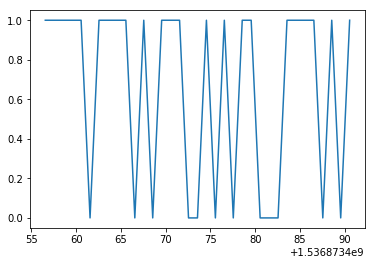

In [305]:
plt.plot(bins, read_times)